In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from mordred import Calculator, descriptors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('df_after_1.csv')
df

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv
0,gdb_110484,OCC1C2C3C4C3N2C14,4.15220,1.30144,1.28565,2.9435,73.48,-0.2206,0.0680,0.2886,1032.1364,0.149188,-401.843805,-401.836710,-401.835765,-401.875622,28.162
1,gdb_59519,CC(C)N1CC2(O)CC12,3.57151,1.05864,0.91649,1.9151,83.22,-0.2031,0.0778,0.2808,1355.5179,0.192384,-404.300200,-404.290625,-404.289681,-404.334092,37.021
2,gdb_100709,CC(C[NH3+])C(C)C([O-])=O,1.86470,1.42956,0.90340,6.4518,78.47,-0.2383,0.0387,0.2770,1351.2924,0.194261,-441.526249,-441.516139,-441.515195,-441.561340,37.768
3,gdb_125535,Cc1[nH]c2nncn2n1,5.53546,1.33654,1.08389,6.1553,69.36,-0.2341,-0.0088,0.2253,1043.1183,0.103847,-429.057325,-429.050396,-429.049452,-429.088666,26.083
4,gdb_49633,O=CC1C2NC3C2OC13,3.37315,1.60041,1.39257,3.4683,67.26,-0.2428,-0.0158,0.2269,929.4179,0.125557,-437.821546,-437.814878,-437.813934,-437.853014,26.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gdb_112723,CC1CC(CO)C1(C)O,2.34958,1.12286,0.95038,1.7937,81.63,-0.2452,0.0686,0.3138,1375.8600,0.203407,-425.417631,-425.407049,-425.406104,-425.452654,39.932
19996,gdb_116135,CC1=NC(CO)CCO1,2.52320,1.27338,0.89207,3.0370,77.62,-0.2439,0.0201,0.2640,1316.7216,0.171822,-440.311380,-440.302401,-440.301457,-440.345239,33.498
19997,gdb_124411,CC(C#C)N1N=CN=N1,3.29260,1.20801,1.10095,2.7110,72.12,-0.2824,-0.0274,0.2549,1131.3310,0.112589,-412.935641,-412.927436,-412.926492,-412.969662,29.218
19998,gdb_2001,CC(O)CN1CC1,5.90365,1.56167,1.33416,2.1208,64.80,-0.2291,0.0703,0.2995,936.0565,0.158800,-326.941692,-326.933626,-326.932682,-326.973925,29.445


Вычисление дескрипторов для каждой строки датафрейма, содержащий информацию о параметре "smiles"

In [3]:
descript = []

for smile in df['smiles']:
  graf = Chem.MolFromSmiles(smile)
  if graf is not None:
    descriptor_values = [v(graf) for _, v in Descriptors._descList]
    descript.append(descriptor_values)
  else:
    descript.append([None] * len(Descriptors._descList))

names = [x[0] for x in Descriptors._descList]

rdkit = pd.DataFrame(descript, columns=names)
rdkit = pd.concat([df, rdkit], axis=1)

Создание нового датафрейма, содержащий исходные данные и вычисленные дескрипторы

In [4]:
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in rdkit.smiles]
mordred = calc.pandas(mols)
res = pd.concat([rdkit, mordred], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [15:44<00:00, 21.18it/s]


Очищаем данные, заменяя NaN и пытаемся заменить на тип данных float

In [5]:
obj_cols = res.select_dtypes(include=['object']).columns
cols_to_drop = []
for col in obj_cols:
    res[col] = res[col].apply(lambda x: np.nan if col in str(x) else x)

for col in res.columns:
    try:
        res[col] = res[col].astype(float)
    except ValueError:
        pass

Фильтрация столбцов, оставляем только те, где NaN в кол-ве не больше 100 

In [6]:
res = res.loc[:,res.isnull().sum() <= 100]

features будет содержать только числовые признаки, а строки с NaN будут удалены

In [7]:
res = res.loc[:,~res.columns.duplicated()]
res.dropna(inplace=True)
numeric_columns = list(res.select_dtypes(include=['float64', 'int64']).columns)
features = res[numeric_columns]

Построение корреляционной матрицы для отслеживания наиболее значимых параметров

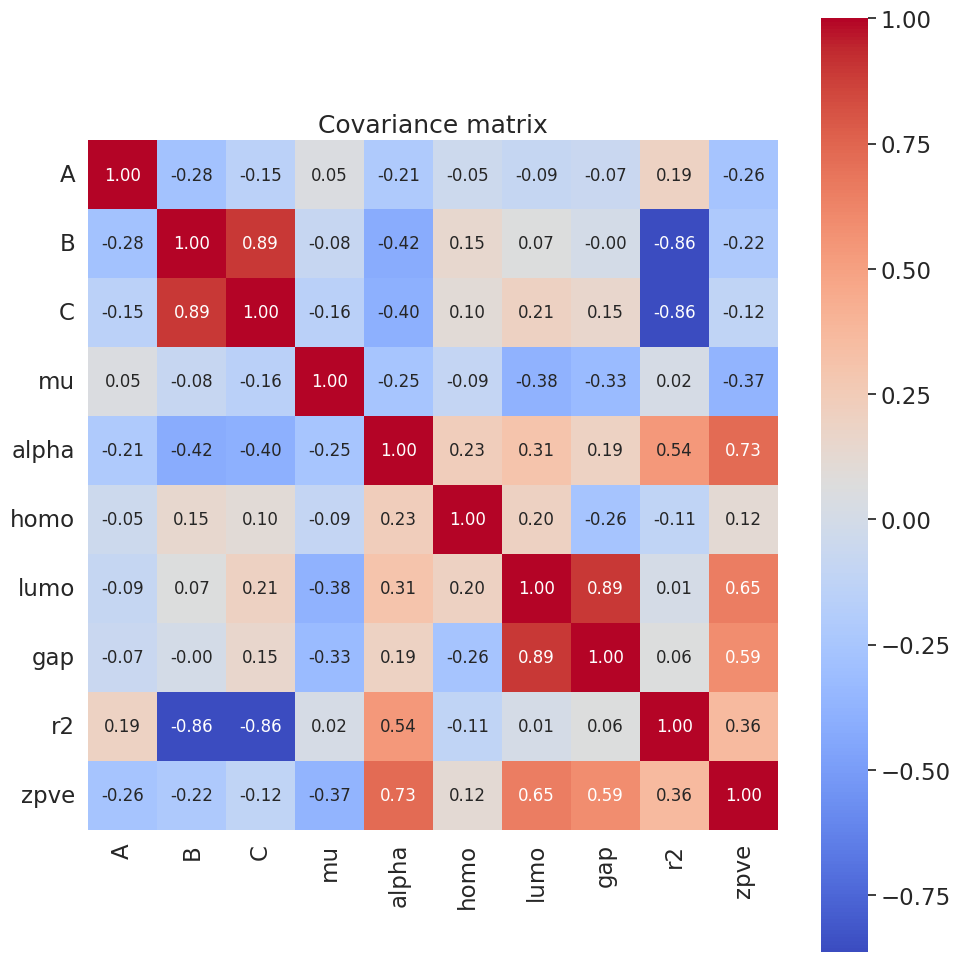

In [8]:
cols = features.columns[:10]

stdsc = StandardScaler()
X_std = stdsc.fit_transform(features[cols].iloc[:,range(10)].values)

cov_mat =np.cov(X_std.T)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix', size = 18)
plt.tight_layout()
plt.show()

Удаляем параметры с высокой корреляцией между признаками

In [9]:
FILTER_THRESHOLD = 0.9

reduced_features = features.drop('gap', axis=1)
cols = reduced_features.columns
stdsc = StandardScaler()
X_std = stdsc.fit_transform(reduced_features[cols].iloc[:,range(reduced_features.shape[1])].values)

cov_mat =np.cov(X_std.T)

cov_mat_df = pd.DataFrame(cov_mat, columns=cols)

upper_tri = cov_mat_df.where(
    np.triu(
        np.ones(cov_mat_df.shape), k=1).astype(bool)
        )

to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > FILTER_THRESHOLD)]
df_after_corr = res.drop(to_drop, axis=1)

Отбор признаков

In [10]:
X = features.drop('gap', axis = 1)
y = features['gap']

estimator = RandomForestRegressor(n_jobs=-1)

sfs1 = sfs(estimator,
           n_features_to_select=250,
           scoring='r2',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X, y)
print(sfs1.support_)

KeyboardInterrupt: 

In [24]:
df_after_corr.to_csv('my_data2.csv', index = False)